In [81]:
import praw
import re
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from os import getenv

try:
    from dotenv import load_dotenv
    load_dotenv(".env", encoding='utf8')
    print("Environment variables loaded!")
except Exception as e:
    print(e)

Environment variables loaded!


# Data Extraction

In [50]:
reddit = praw.Reddit(client_id=getenv("CLIENT_ID"), client_secret=getenv("CLIENT_SECRET"), user_agent="praw_scraper_1.0")

In [51]:
subreddit = reddit.subreddit("PTOrdenado")

In [52]:
df = pd.DataFrame(columns=["Title", "Age", "Sex", "Experience", "Education", "Labor Hours", "Total Salary", "Salary"])

In [53]:
def is_portugal_city(cities):
    has_pt = list()
    
    for city in cities:
        reg = re.search("\w+", city)
        if reg:
            response = requests.request("GET", f"https://www.geonames.org/search.html?q={reg.group(0)}&country=")
            countries = re.findall("/countries.*\.html", response.text)[0].strip(".html").split("/")[-1]
            has_pt.append("portuga" in countries)
        else:
            has_pt.append(False)
    return any(has_pt)

In [54]:
regex_roles = re.compile(r"data|dados|machine learning|\sai^\w|\sia^\w|inteligência artificial|artificial intelligence")
regex_age_str = re.compile(r"Idade.*")
regex_sex = re.compile(r"\([MF]\)|\s[FM]")
regex_xp_str = re.compile(r"Experiência profissional.*")
regex_education = re.compile(r"Formação académica.*")
regex_hours = re.compile(r"Horas de trabalho.*")
regex_total = re.compile(r"Salário bruto.*")
regex_salary = re.compile(r"Salário líquido.*")
regex_city = re.compile(r"região de trabalho.*")


for i, sub in enumerate(subreddit.new(limit=None)):  
    if sub.link_flair_text == "IT / Programação" and regex_roles.search(sub.title.lower()):
        # Age and Sex
        age_str = regex_age_str.search(sub.selftext)
        if age_str:
            age = re.search(r"\d+", age_str.group(0))
            if age:
                age = int(age.group(0))
            else:
                age = np.nan
        
            # Sex
            sex = np.nan
            sex_str =  regex_sex.search(age_str.group(0))
            if sex_str:
                sex = "M" if "M" in sex_str.group(0) else "F"
        else:
            age = np.nan
            sex = np.nan
        
        # years of experience
        xp_str = regex_xp_str.search(sub.selftext)

        if xp_str:
            xp = re.search("\d+\.\d+|\d+\,\d+|\d+", xp_str.group(0))
            if xp:
                xp = float(xp.group(0).replace(",", "."))
        else:
            xp = np.nan
        
        # Education: Bachelors or Masters degree
        edu = regex_education.search(sub.selftext)
        mat = "No"
        if edu:
            tmp_edu = edu.group(0).lower()
            if "licenciatura" in tmp_edu:
                edu = "BsC"
            elif "mestrado" in tmp_edu:
                edu = "MsC"
            elif "doutorado" in tmp_edu or "doutoramento" in tmp_edu or "phd" in tmp_edu:
                edu = "PhD"
            else:
                edu = np.nan

            # If it is a degree in math and/or statistics
            if edu != np.nan and ("matemática" in tmp_edu or "estatística" in tmp_edu):
                mat = "Yes"
        else:
            edu = np.nan

        # Labor hours
        h = regex_hours.search(sub.selftext)
        hours = np.nan
        if h:
            hours = re.search(r"\d+", h.group(0))
            if hours:
                hours = float(hours.group(0))
            else:
                hours = np.nan
        
        # salary and total salary per month
        total = regex_total.search(sub.selftext)
        if total:
            total_sal = re.search("\d+", total.group(0))
            if total_sal:
                total_sal = float(total_sal.group(0))
            else:
                total_sal = np.nan
        else:
            total_sal = np.nan
        
        sal = regex_salary.search(sub.selftext)
        salary = np.nan
        if sal:
            salary = re.search("\d+", sal.group(0))
            if salary:
                salary = float(salary.group(0))
            else:
                salary = np.nan

        # Work in Portugal?
        region = regex_city.search(sub.selftext)
        if region:
            cities = region.group(0).split(":")[1].split(" ")
            region = "Yes" if is_portugal_city(cities) else "No"
        else:
            region = np.nan
        
        df_tmp = pd.DataFrame({
            "Title": [sub.title,],
            "Age": [age,],
            "Sex": [sex,],
            "Labor Hours": [hours,], 
            "Education": [edu,], 
            "Mathematics": [mat,],
            "Experience": [xp,], 
            "Portugal": [region,],
            "Total Salary": [total_sal,], 
            "Salary": [salary,]
        })
        df = pd.concat([df, df_tmp], ignore_index=True)

C:\Users\f\AppData\Local\Temp\ipykernel_5780\3869856959.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_tmp], ignore_index=True)


# Data analysis

**Title**: Name of the job

**Age**: Age of the person

**Sex**: Sex of the person

**Experience**: Years of experience

**Education**: If has Bachelors or Masters degree

**Labor Hours**: Hours of work per week

**Total Salary**: Salary without taxes, in euros

**Salary**: Salary with taxes applied, in euros

**Mathematics**: If the BsC or MsC is in mathematics or not (it's interesting for me)

In [55]:
df

,Title,Age,Sex,Experience,Education,Labor Hours,Total Salary,Salary,Mathematics,Portugal
0,Estagiário Análise de Dados,23,M,1.0,MsC,40.0,1150.0,1050.0,No,Yes
1,Engenheiro de machine learning,24,M,1.0,MsC,40.0,2050.0,1611.0,No,Yes
2,Data Analyst,37,F,4.0,MsC,40.0,2150.0,1650.0,No,Yes
3,Analista de Dados,26,M,3.0,MsC,40.0,2600.0,1800.0,No,Yes
4,Data Scientist Luxemburgo,24,M,3.0,BsC,40.0,4460.0,3500.0,Yes,No
5,Data Analyst,28,F,2.0,MsC,40.0,1620.0,1220.0,No,Yes
6,Data Engineer,29,M,4.5,MsC,40.0,3150.0,2000.0,No,Yes
7,Engenheiro de Dados,26,M,3.0,MsC,40.0,2000.0,1523.0,No,Yes
8,Data Center Engineer,25,M,2.0,NaN,40.0,2160.0,1550.0,No,Yes
9,Data Engineer,26,NaN,4.5,BsC,40.0,5667.0,4233.0,No,No


### Salaries
Sometimes salaries are not in decimal representation but in "k" representation, e.g **2k**

Since salaries doesn't pass tens of thousands at maximum, we can verify if salary's remainder by 100 is equal to salary, if yes multiply by 1000, because it didn't pass 100 and anything below 100 can't be a valid Portugal's salary represented in decimal.

In [56]:
df["Salary"] = df["Salary"].apply(lambda x: x * 1000 if x % 100 == x else x)
df["Total Salary"] = df["Total Salary"].apply(lambda x: x * 1000 if x % 100 == x else x)

In [57]:
df

,Title,Age,Sex,Experience,Education,Labor Hours,Total Salary,Salary,Mathematics,Portugal
0,Estagiário Análise de Dados,23,M,1.0,MsC,40.0,1150.0,1050.0,No,Yes
1,Engenheiro de machine learning,24,M,1.0,MsC,40.0,2050.0,1611.0,No,Yes
2,Data Analyst,37,F,4.0,MsC,40.0,2150.0,1650.0,No,Yes
3,Analista de Dados,26,M,3.0,MsC,40.0,2600.0,1800.0,No,Yes
4,Data Scientist Luxemburgo,24,M,3.0,BsC,40.0,4460.0,3500.0,Yes,No
5,Data Analyst,28,F,2.0,MsC,40.0,1620.0,1220.0,No,Yes
6,Data Engineer,29,M,4.5,MsC,40.0,3150.0,2000.0,No,Yes
7,Engenheiro de Dados,26,M,3.0,MsC,40.0,2000.0,1523.0,No,Yes
8,Data Center Engineer,25,M,2.0,NaN,40.0,2160.0,1550.0,No,Yes
9,Data Engineer,26,NaN,4.5,BsC,40.0,5667.0,4233.0,No,No


# Labor Hours
Since labor hours are constant, for now, and a constant variable will not help in anything, we'll remove it

In [58]:
df.drop(columns=["Labor Hours"], inplace=True)
df

,Title,Age,Sex,Experience,Education,Total Salary,Salary,Mathematics,Portugal
0,Estagiário Análise de Dados,23,M,1.0,MsC,1150.0,1050.0,No,Yes
1,Engenheiro de machine learning,24,M,1.0,MsC,2050.0,1611.0,No,Yes
2,Data Analyst,37,F,4.0,MsC,2150.0,1650.0,No,Yes
3,Analista de Dados,26,M,3.0,MsC,2600.0,1800.0,No,Yes
4,Data Scientist Luxemburgo,24,M,3.0,BsC,4460.0,3500.0,Yes,No
5,Data Analyst,28,F,2.0,MsC,1620.0,1220.0,No,Yes
6,Data Engineer,29,M,4.5,MsC,3150.0,2000.0,No,Yes
7,Engenheiro de Dados,26,M,3.0,MsC,2000.0,1523.0,No,Yes
8,Data Center Engineer,25,M,2.0,NaN,2160.0,1550.0,No,Yes
9,Data Engineer,26,NaN,4.5,BsC,5667.0,4233.0,No,No


# Education
Education is an ordinal variable, because MsC is higher than BsC and PhD higher than MsC. NaN will be no degree.

So we'll use integer values for these variable.

In [59]:
def edu_2_int(x):
    if x == "BsC":
        return 1
    elif x == "MsC":
        return 2
    elif x == "PhD":
        return 3
    return 0

df["Education"] = df["Education"].apply(edu_2_int)

In [60]:
df

,Title,Age,Sex,Experience,Education,Total Salary,Salary,Mathematics,Portugal
0,Estagiário Análise de Dados,23,M,1.0,2,1150.0,1050.0,No,Yes
1,Engenheiro de machine learning,24,M,1.0,2,2050.0,1611.0,No,Yes
2,Data Analyst,37,F,4.0,2,2150.0,1650.0,No,Yes
3,Analista de Dados,26,M,3.0,2,2600.0,1800.0,No,Yes
4,Data Scientist Luxemburgo,24,M,3.0,1,4460.0,3500.0,Yes,No
5,Data Analyst,28,F,2.0,2,1620.0,1220.0,No,Yes
6,Data Engineer,29,M,4.5,2,3150.0,2000.0,No,Yes
7,Engenheiro de Dados,26,M,3.0,2,2000.0,1523.0,No,Yes
8,Data Center Engineer,25,M,2.0,0,2160.0,1550.0,No,Yes
9,Data Engineer,26,NaN,4.5,1,5667.0,4233.0,No,No


# Mathematics and Portugal
Both are nominal variables and are clearly binary variables.

Now, after see the data of both variables, non-portugal workers receive a lot more, so could be useful to determine the salary.

Perhaps, mathematics doesn't seem important.

In [61]:
df["Mathematics"] = df["Mathematics"].apply(lambda x: 1 if x == "Yes" else 0)
df["Portugal"] = df["Portugal"].apply(lambda x: 1 if x == "Yes" else 0)
df

,Title,Age,Sex,Experience,Education,Total Salary,Salary,Mathematics,Portugal
0,Estagiário Análise de Dados,23,M,1.0,2,1150.0,1050.0,0,1
1,Engenheiro de machine learning,24,M,1.0,2,2050.0,1611.0,0,1
2,Data Analyst,37,F,4.0,2,2150.0,1650.0,0,1
3,Analista de Dados,26,M,3.0,2,2600.0,1800.0,0,1
4,Data Scientist Luxemburgo,24,M,3.0,1,4460.0,3500.0,1,0
5,Data Analyst,28,F,2.0,2,1620.0,1220.0,0,1
6,Data Engineer,29,M,4.5,2,3150.0,2000.0,0,1
7,Engenheiro de Dados,26,M,3.0,2,2000.0,1523.0,0,1
8,Data Center Engineer,25,M,2.0,0,2160.0,1550.0,0,1
9,Data Engineer,26,NaN,4.5,1,5667.0,4233.0,0,0


# Age

Here to fix missing values, using the mean should be reasonable, since the mean will act as a "neutral" value on the variable distribution.

In [62]:
df["Age"].fillna(int(df["Age"].mean()), inplace=True)
df

,Title,Age,Sex,Experience,Education,Total Salary,Salary,Mathematics,Portugal
0,Estagiário Análise de Dados,23,M,1.0,2,1150.0,1050.0,0,1
1,Engenheiro de machine learning,24,M,1.0,2,2050.0,1611.0,0,1
2,Data Analyst,37,F,4.0,2,2150.0,1650.0,0,1
3,Analista de Dados,26,M,3.0,2,2600.0,1800.0,0,1
4,Data Scientist Luxemburgo,24,M,3.0,1,4460.0,3500.0,1,0
5,Data Analyst,28,F,2.0,2,1620.0,1220.0,0,1
6,Data Engineer,29,M,4.5,2,3150.0,2000.0,0,1
7,Engenheiro de Dados,26,M,3.0,2,2000.0,1523.0,0,1
8,Data Center Engineer,25,M,2.0,0,2160.0,1550.0,0,1
9,Data Engineer,26,NaN,4.5,1,5667.0,4233.0,0,0


# Sex 
Unfortunately, in this small sample we can observe a lot more males than females working. Since it's a nominal variable, we will just use mode.

If the sample increase and more NaN appear than a dummy variable will be create to support "Other" option on this variable.

For now it'll be a binary variable

In [66]:
df["Sex"].fillna(df["Sex"].mode()[0], inplace=True)
df["Sex"] = df["Sex"].apply(lambda x: 1 if x == "M" else 0)
df

,Title,Age,Sex,Experience,Education,Total Salary,Salary,Mathematics,Portugal
0,Estagiário Análise de Dados,23,1,1.0,2,1150.0,1050.0,0,1
1,Engenheiro de machine learning,24,1,1.0,2,2050.0,1611.0,0,1
2,Data Analyst,37,0,4.0,2,2150.0,1650.0,0,1
3,Analista de Dados,26,1,3.0,2,2600.0,1800.0,0,1
4,Data Scientist Luxemburgo,24,1,3.0,1,4460.0,3500.0,1,0
5,Data Analyst,28,0,2.0,2,1620.0,1220.0,0,1
6,Data Engineer,29,1,4.5,2,3150.0,2000.0,0,1
7,Engenheiro de Dados,26,1,3.0,2,2000.0,1523.0,0,1
8,Data Center Engineer,25,1,2.0,0,2160.0,1550.0,0,1
9,Data Engineer,26,1,4.5,1,5667.0,4233.0,0,0


## Standardization
Standardization will result in the same porpotion for all variables.

The only variables we'll not standardize are the binary ones, unless we use PCA or some algoritm sensible to different scales.

In [70]:
cols = df.columns

for c in (set(cols) - {"Title", "Sex", "Mathematics", "Portugal"}):
    df[c] = df[c].apply(lambda x: (x - df[c].mean())/df[c].std())
df

,Title,Age,Sex,Experience,Education,Total Salary,Salary,Mathematics,Portugal
0,Estagiário Análise de Dados,-1.072608,1,-1.132922,0.470598,-1.399021,-1.298984,0,1
1,Engenheiro de machine learning,-0.870831,1,-1.132922,0.470598,-0.749144,-0.687741,0,1
2,Data Analyst,1.752281,0,-0.139437,0.470598,-0.676936,-0.645248,0,1
3,Analista de Dados,-0.467275,1,-0.470598,0.470598,-0.351997,-0.481814,0,1
4,Data Scientist Luxemburgo,-0.870831,1,-0.470598,-1.019630,0.991081,1.370436,1,0
5,Data Analyst,-0.063719,0,-0.801760,0.470598,-1.059641,-1.113759,0,1
6,Data Engineer,0.138059,1,0.026144,0.470598,0.045149,-0.263903,0,1
7,Engenheiro de Dados,-0.467275,1,-0.470598,0.470598,-0.785248,-0.783622,0,1
8,Data Center Engineer,-0.669053,1,-0.801760,-2.509858,-0.669715,-0.754204,0,1
9,Data Engineer,-0.467275,1,0.026144,-1.019630,1.862637,2.169082,0,0


## Linear dependencies

Let's check how linearly correlated are each variable.

`Title` and `Salary` will be removed because the first one is just for being informative and the second because it will be our target variable. 

array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Sex', ylabel='Age'>,
        <Axes: xlabel='Experience', ylabel='Age'>,
        <Axes: xlabel='Education', ylabel='Age'>,
        <Axes: xlabel='Total Salary', ylabel='Age'>,
        <Axes: xlabel='Mathematics', ylabel='Age'>,
        <Axes: xlabel='Portugal', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Sex'>,
        <Axes: xlabel='Sex', ylabel='Sex'>,
        <Axes: xlabel='Experience', ylabel='Sex'>,
        <Axes: xlabel='Education', ylabel='Sex'>,
        <Axes: xlabel='Total Salary', ylabel='Sex'>,
        <Axes: xlabel='Mathematics', ylabel='Sex'>,
        <Axes: xlabel='Portugal', ylabel='Sex'>],
       [<Axes: xlabel='Age', ylabel='Experience'>,
        <Axes: xlabel='Sex', ylabel='Experience'>,
        <Axes: xlabel='Experience', ylabel='Experience'>,
        <Axes: xlabel='Education', ylabel='Experience'>,
        <Axes: xlabel='Total Salary', ylabel='Experience'>,
        <Axes: xlabel='Mathematics'

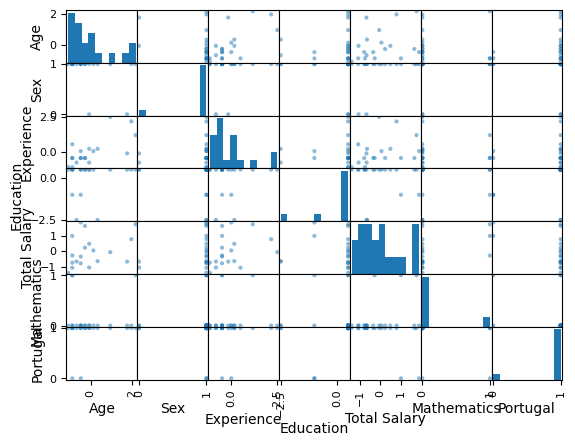

In [78]:
df_train = df.drop(columns=["Title", "Salary"])
pd.plotting.scatter_matrix(df_train)

In [79]:
df_train.corr()

,Age,Sex,Experience,Education,Total Salary,Mathematics,Portugal
Age,1.000000,-0.297521,0.712661,0.165294,0.329366,0.061419,0.235772
Sex,-0.297521,1.000000,0.165837,-0.165837,0.305981,0.148522,-0.117647
Experience,0.712661,0.165837,1.000000,0.137807,0.349254,0.036185,0.078312
Education,0.165294,-0.165837,0.137807,1.000000,-0.017824,-0.011631,0.359313
Total Salary,0.329366,0.305981,0.349254,-0.017824,1.000000,0.363813,-0.502819
Mathematics,0.061419,0.148522,0.036185,-0.011631,0.363813,1.000000,-0.321798
Portugal,0.235772,-0.117647,0.078312,0.359313,-0.502819,-0.321798,1.000000


**Positively correlated**
* `Age` and `Experience` - More age implies in more experience
* `Age` and `Total Salary` - More age implies better salaries

**Negatively correlated**
* `Portugal` and `Total Salary` - Living in Portugal implies in less salaries


Other variables have little positive correlation by the numbers or by the graph, but don't seem important.

We can't really compare categorical variables using correlation. 